# Data

In [58]:
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from simulatedata import simulatedata

# Set kbar
kbar = 4

# Simulated data, 60% in-sample for estimation, 40% out-of-sample for forecasts.  See Section 4 re rationale for simulated data
b = 6
m0 = 1.6
gamma_kbar = 0.8
sig = 2/np.sqrt(252)    
T = 56550
E = np.rint(0.6*T).astype(int)            
dat1 = simulatedata(b,m0,gamma_kbar,sig,kbar,T)
dat1E = dat1[0:E,]
dat1F = dat1[E:,]

# taking the values of our 1sigma
dat2=pd.read_csv('sigma_1m.csv')
dat2=dat2[['log_ret']].dropna()
dat2=dat2.values
n=int(len(dat2)*0.6) # 33930 training data
dat2E = dat2[0:n,]
dat2F = dat2[n:,]



dat1E.shape, dat1F.shape, dat2E.shape, dat2F.shape

((33930, 1), (22620, 1), (33930, 1), (22620, 1))

# Stats

In [59]:
from scipy import stats

j = stats.describe(dat2)
print("Descriptive statistics for Simulated Data: ","\n"
      "Number of observations = ",j.nobs,"\n"
      "Minimum, Maximum = ",str(j.minmax),"\n"
      "Mean = %.5f" %  j.mean,"\n"
      "Variance = %.5f" %  j.variance,"\n"
      "Standard deviation = %.5f" %  j.variance**0.5,"\n"
      "Skewness = %.5f" %  j.skewness,"\n"
      "Kurtosis = %.5f" %  j.kurtosis)



Descriptive statistics for Simulated Data:  
Number of observations =  56550 
Minimum, Maximum =  (array([-0.03990028]), array([0.03959224])) 
Mean = 0.00000 
Variance = 0.00000 
Standard deviation = 0.00034 
Skewness = -0.68199 
Kurtosis = 6363.66677


# Time series analysis

In [34]:
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", palette="muted")

def tsdisplay(y, figsize = (16,9), title = "", color = ""):
    tmp_data = pd.Series(y)
    
    fig = plt.figure(figsize = figsize)
    # Plot time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Log\ returns\ time\ series:\ " + title + "$", legend = False, color=color, linewidth=0.5, alpha=0.75)
    # Plot ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(323))
    # Plot PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(324))
    # QQ plot of the data:
    sm.qqplot(tmp_data, line='s', color=color, ax = fig.add_subplot(325)) 
    plt.title("Q-Q Plot")
    # Plot residual histogram:
    fig.add_subplot(326).hist(tmp_data, color=color, bins = 120)
    plt.title("Histogram")
    # Fix layout of the plots:
    plt.tight_layout()

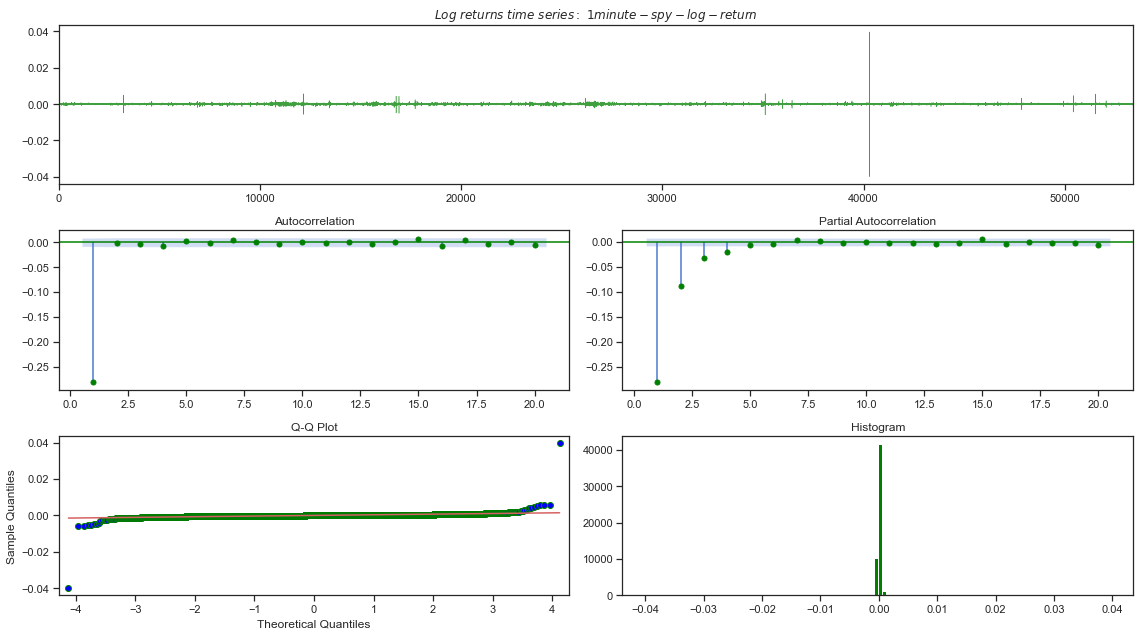

In [48]:
s = np.array(dat2).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "1minute-spy-log-return", color='green')

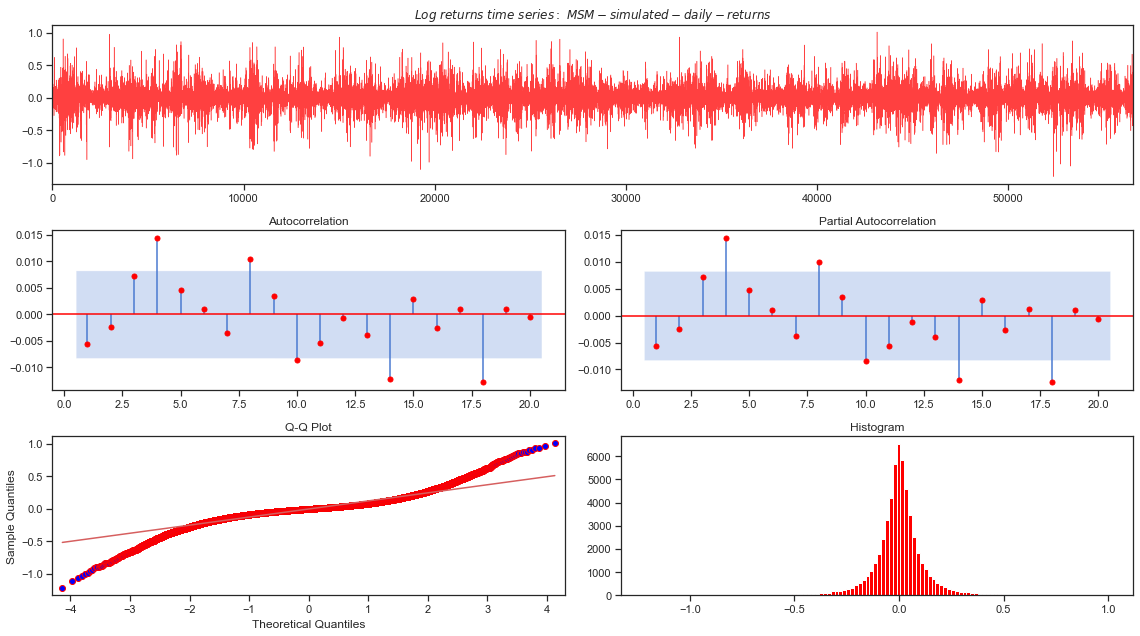

In [47]:
s = np.array(dat1).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "MSM-simulated-daily-returns", color='red')

# Model estimation

__Fisher Paper__   
**Simulated dataset**

I apply ML estimation to the simulated dataset to replicate the results of Calvet & Fisher (2004, 2008) with the same data, thereby providing an anchor for subsequent analysis with other data.

I apply ML estimation to the simulated dataset in order to check that my models compute parameters that are acceptably close to true. The function `simulateData_NumPy(b,m0,g_kbar,sig,kbar,T)` simulates a dataset the true parameters of which are $b = 6$, $m_0 = 1.6$, $gamma_{\bar k} = 0.8$, and ${\bar \sigma} = 2$; I further specify 5 multipliers (thus $\bar k = 5$). I set $T$ observations for the simulation, setting $T = 56550$ in order that the simulated data set is of identical length (number of observations) to the spy dataset of the subsequent section, where I replicate the results of Calvet & Fisher (2004).  I observe that the parameters returned for the simulated data are consistently close to the true parameters, thus that the MSM model is working correctly.



In [51]:
import numpy as np
from msm import glo_min, loc_min, g_LLb_h, g_LL, _LL, g_pi_t, _t, g_t, s_p, unpack 

data = dat1E               # DEXJPUS
niter = 1
temperature = 1.0
stepsize = 1.0

parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
# name parameters for later use:

b_dex = parameters[0]
m_0_dex = parameters[1]
gamma_kbar_dex = parameters[2]
sigma_dex = parameters[3]
LL_dex = LL

print("Parameters from glo_min for DEXJPUS: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_dex,"\n"
      'm_0 = %.5f' % m_0_dex,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_dex,"\n"
      'sigma = %.5f' % (sigma_dex*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_dex,"\n"
      "niter = " , niter,"\n"
      "output = " , output,"\n")

Parameters from glo_min for DEXJPUS:  
kbar =  4 
b = 6.21582 
m_0 = 1.59348 
gamma_kbar = 0.81672 
sigma = 1.99716 
Likelihood = -30601.23483 
niter =  1 
output =  ['requested number of basinhopping iterations completed successfully'] 



__Maximum likelihood estimation of our data set__

I apply ML estimation to the spy data.


***

In [50]:
import numpy as np
from msm import glo_min, loc_min, g_LLb_h, g_LL, _LL, g_pi_t, _t, g_t, s_p, unpack 

data = dat2E            # Simulated dta
niter = 1
temperature = 1.0
stepsize = 1.0

parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for Simulated dataset: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      "niter = " , niter,"\n"
      "output = " , output,"\n")

Parameters from glo_min for Simulated dataset:  
kbar =  4 
b = 14.83679 
m_0 = 1.53267 
gamma_kbar = 0.28359 
sigma = 0.00641 
Likelihood = -238538.76692 
niter =  1 
output =  ['requested number of basinhopping iterations completed successfully'] 

